# Loading data

In [ ]:
# Install dependencies
pip install optuna

In [68]:
# Import libraries
import pandas as pd
import json
import numpy as np
import torch
import random
import os
import optuna
import warnings
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from torch import nn
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader


# Suppress specific Optuna warning about categorical distributions
warnings.filterwarnings("ignore", category=UserWarning, module="optuna.distributions")


In [69]:
# Load the JSON Lines file into a DataFrame
df1 = pd.read_json('domain1_train_data.json', lines=True)
df2 = pd.read_json('domain2_train_data.json', lines=True)
df_test = pd.read_json('test_data.json', lines=True)

# Inspect data
df1.head()

,text,label,id
0,"[6, 22, 34, 76, 501, 977, 1, 2514, 13623, 76, ...",0,0
1,"[222, 31, 4108, 104, 132, 361, 39, 2305, 12, 9...",0,1
2,"[736, 7194, 113, 12, 366, 2870, 123, 101, 12, ...",0,2
3,"[48, 1, 2025, 69, 361, 533, 327, 237, 4150, 13...",0,3
4,"[2973, 66, 1, 1493, 260, 2740, 50, 1027, 50, 1...",0,4


# Models implementation and Hyper-parameter tuning on validation set

In [121]:
# Combine data from two domains into a single DataFrame
df = pd.concat([df1, df2], ignore_index=True)

# Convert token index lists to space-separated strings
df["text_str"] = df["text"].apply(lambda tokens: " ".join(str(tok) for tok in tokens))

# Split into train - val sets
X_train, X_val, y_train, y_val = train_test_split(
    df["text_str"], df["label"], test_size=0.2, random_state=42
)

# Vectorize using Bag-of-Words
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_val_bow = vectorizer.transform(X_val)

In [122]:
# Find vocab size for Multitask CNN by looking at the highest index
max_index = df['text'].apply(lambda tokens: max(tokens) if tokens else 0).max() 
print(f"Vocabulary size: {max_index + 1}") # +1 because indices start at 0

Vocabulary size: 17120


## Baseline: Multinomial Naive Bayes

In [123]:
# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, y_train)

# Predict and evaluate on validation set
y_pred = nb_model.predict(X_val_bow)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       187
           1       0.94      0.95      0.95      1013

    accuracy                           0.91      1200
   macro avg       0.83      0.82      0.83      1200
weighted avg       0.91      0.91      0.91      1200



## Logistic Regression

In [124]:
lr_model = LogisticRegression()

# Hyper-parameters to be tuned
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'],
    'max_iter': [100, 300, 500]
}

# Grid search with cross-validation
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='f1_macro', verbose=2, n_jobs=-1)
grid_search.fit(X_train_bow, y_train)

# Evaluate best params
print("Best Parameters:", grid_search.best_params_)
print("\nPerformance on validation set:")
y_pred = grid_search.predict(X_val_bow)
print(classification_report(y_val, y_pred))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

Performance on validation set:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       187
           1       0.95      0.99      0.97      1013

    accuracy                           0.95      1200
   macro avg       0.94      0.86      0.89      1200
weighted avg       0.95      0.95      0.95      1200



## Multi-task CNN

In [88]:
# Enable GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=42):
    '''This function sets seed to allows reproducibility'''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For CUDA reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)
torch.use_deterministic_algorithms(True)

In [89]:
# Define Gradient Reversal 
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None # flip gradient (multiply by negative number)

class GradientReversalLayer(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)
    
    
# Defining the Multitask CNN architecture
class MultiTaskCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, num_domains, kernel_sizes, num_filters, dropout):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Apply CNN filters to extract patterns
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])
        
        # Random dropout
        self.dropout = nn.Dropout(dropout)
        self.feature_dim = num_filters * len(kernel_sizes)

        # Main task head (human vs machine)
        self.classifier = nn.Linear(self.feature_dim, num_classes)

        # Domain classifier head (with gradient reversal)
        self.grl = GradientReversalLayer()
        self.domain_classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 100),
            nn.ReLU(), # ReLU activation function for domain classifier
            nn.Linear(100, num_domains)
        )

    def forward(self, x, alpha=1.0):
        """
        x: [batch_size, seq_len]
        alpha: gradient reversal strength
        """
        embedded = self.embedding(x)  
        embedded = embedded.transpose(1, 2)
        
        conv_outputs = [torch.relu(conv(embedded)) for conv in self.convs] # ReLU for each convolutional layer
        pooled = [torch.max(out, dim=2)[0] for out in conv_outputs]  # global max pooling
        features = torch.cat(pooled, dim=1)
        features = self.dropout(features)

        # Main task prediction
        class_logits = self.classifier(features)

        # Domain task prediction with gradient reversal
        reversed_features = self.grl(features)
        domain_logits = self.domain_classifier(reversed_features)

        return class_logits, domain_logits

In [90]:
# TextDomainDataset is to process input training data
class TextDomainDataset(Dataset):
    def __init__(self, json_file, domain_label):
        """
        json_file: path to the JSON file containing lines like:
            {"text": [indices], "label": 0 or 1, "id": int}
        domain_label: 0 or 1 indicating domain for all samples in this file
        """
        self.samples = []
        self.domain_label = domain_label
        with open(json_file, 'r') as f:
            for line in f:
                item = json.loads(line)
                self.samples.append(item)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        text_tensor = torch.tensor(sample['text'], dtype=torch.long)
        label = sample['label']
        domain = self.domain_label
        sample_id = sample.get('id', idx)
        return text_tensor, label, domain, sample_id

'''This function prepares batches of data by ensuring all sequences are 
padded to the same length and ready to put into Multitask CNN'''    
def collate_batch(batch):
    # batch is a list of tuples: (text_tensor, label, domain, id)
    texts, labels, domains, ids = zip(*batch)
    lengths = [len(t) for t in texts]
    max_len = max(lengths)

    # pad sequences
    padded_texts = torch.zeros(len(texts), max_len, dtype=torch.long)
    for i, t in enumerate(texts):
        padded_texts[i, :lengths[i]] = t

    labels = torch.tensor(labels, dtype=torch.long)
    domains = torch.tensor(domains, dtype=torch.long)
    ids = torch.tensor(ids, dtype=torch.long)
    return padded_texts, labels, domains, ids

In [91]:
# Process input training data with TextDomainDataset
domain0_file = 'domain1_train_data.json'
domain1_file = 'domain2_train_data.json'

dataset0 = TextDomainDataset(domain0_file, domain_label=0)
dataset1 = TextDomainDataset(domain1_file, domain_label=1)

# Combine datasets
full_dataset = torch.utils.data.ConcatDataset([dataset0, dataset1])

# Split train and val (80-20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # ensures consistent split across runs
)

# Prepare batches of data to be ready for MultiTask CNN
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, 
                          worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id), # ensure reproducibility
                          generator=torch.Generator().manual_seed(42), collate_fn=collate_batch)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

In [114]:
def train_epoch(model, dataloader, optimizer, device, alpha=1.0):
    '''This function takes in the training data to train the CNN model.
    It outputs average CrossEntropyLoss across all batches'''
    model.train()
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    for inputs, labels, domains, _ in dataloader:
        inputs, labels, domains = inputs.to(device), labels.to(device), domains.to(device)

        optimizer.zero_grad()
        class_logits, domain_logits = model(inputs, alpha=alpha)

        class_loss = criterion(class_logits, labels)
        domain_loss = criterion(domain_logits, domains)
        loss = class_loss + domain_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device):
    '''This function evaluates the model by calculating F1-macro score
    when predicting on validation set'''
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            class_logits, _ = model(inputs, alpha=0.0)
            preds = torch.argmax(class_logits, dim=1) # Predict on validation set
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return f1_score(all_labels, all_preds, average='macro')


In [93]:
'''This function defines the hyper-parameters to be tuned and
return F1-macro score for a trial of model configuration '''
def objective(trial):
    # Hyperparameters to try
    embed_dim = trial.suggest_categorical("embed_dim", [64, 128])
    num_filters = trial.suggest_categorical("num_filters", [50, 100, 200])
    dropout = trial.suggest_float("dropout", 0.3, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    
    kernel_sizes = trial.suggest_categorical("kernel_sizes", [(3,4,5), (2,3,4)])

    # Build model with current trial's hyperparameters
    model = MultiTaskCNN(
        vocab_size=17120,
        embed_dim=embed_dim,
        num_classes=2,
        num_domains=2,
        kernel_sizes=kernel_sizes,
        num_filters=num_filters,
        dropout=dropout
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Early stopping parameters
    best_f1 = 0.0
    patience = 2 # stop if F1 not improve after 2 consecutive epochs
    counter = 0
    max_epochs = 15

    for epoch in range(max_epochs):
        train_epoch(model, train_loader, optimizer, device, alpha=1)
        val_f1 = evaluate(model, val_loader, device)

        # Report intermediate result to Optuna
        trial.report(val_f1, step=epoch)

        # Prune trial if F1 looks not promising
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Check early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break  # Stop early

    return best_f1

In [119]:
# Conduct hyper-parameter tuning with Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best hyperparameters:")
print(study.best_params)

[I 2025-05-24 22:46:10,491] A new study created in memory with name: no-name-d0b7fbe0-2158-4a28-bff3-ff1f125d7113
[I 2025-05-24 22:46:56,221] Trial 0 finished with value: 0.8641338788256707 and parameters: {'embed_dim': 64, 'num_filters': 200, 'dropout': 0.4414792240625735, 'lr': 0.0017108161414496237, 'kernel_sizes': (3, 4, 5)}. Best is trial 0 with value: 0.8641338788256707.
[I 2025-05-24 22:47:39,395] Trial 1 finished with value: 0.8941003431933322 and parameters: {'embed_dim': 128, 'num_filters': 100, 'dropout': 0.4371075348157495, 'lr': 0.004574601011176485, 'kernel_sizes': (2, 3, 4)}. Best is trial 1 with value: 0.8941003431933322.
[I 2025-05-24 22:48:13,520] Trial 2 finished with value: 0.7716724989452262 and parameters: {'embed_dim': 128, 'num_filters': 50, 'dropout': 0.4777296338737531, 'lr': 0.0004931953978904352, 'kernel_sizes': (2, 3, 4)}. Best is trial 1 with value: 0.8941003431933322.
[I 2025-05-24 22:49:40,463] Trial 3 finished with value: 0.8825750162564157 and paramete

Best hyperparameters:
{'embed_dim': 128, 'num_filters': 100, 'dropout': 0.4371075348157495, 'lr': 0.004574601011176485, 'kernel_sizes': (2, 3, 4)}


In [124]:
# Define model with best hyper-parameters found
best_params = study.best_params
model = MultiTaskCNN(
    vocab_size=17120,
    embed_dim=best_params["embed_dim"],
    num_classes=2,
    num_domains=2,
    kernel_sizes=best_params["kernel_sizes"],
    num_filters=best_params["num_filters"],
    dropout=best_params["dropout"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])

# Tracking f1 scores
f1_scores = []

 # Early stopping parameters
best_f1 = 0.0
patience = 3
counter = 0
max_epochs = 15

# Train the final model with best hyper-parameters
for epoch in range(max_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device, alpha=1)
    f1 = evaluate(model, val_loader, device)
    f1_scores.append(f1)
    
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - F1: {f1:.4f}")
    
    # Check early stopping
    if f1 > best_f1:
        best_f1 = f1
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break  # Stop early


Epoch 1 - Train Loss: 0.8700 - F1: 0.5929
Epoch 2 - Train Loss: 0.7611 - F1: 0.7473
Epoch 3 - Train Loss: 0.6527 - F1: 0.8697
Epoch 4 - Train Loss: 0.6241 - F1: 0.6799
Epoch 5 - Train Loss: 0.5837 - F1: 0.8835
Epoch 6 - Train Loss: 0.6407 - F1: 0.8968
Epoch 7 - Train Loss: 0.5935 - F1: 0.8802
Epoch 8 - Train Loss: 0.5973 - F1: 0.8951
Epoch 9 - Train Loss: 0.6628 - F1: 0.8598


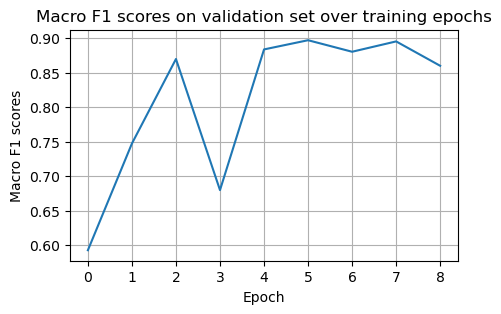

In [132]:
# Plot macro-F1 scores over training epochs
plt.figure(figsize=(5, 3))
plt.plot(f1_scores)
plt.xlabel('Epoch')
plt.ylabel('Macro F1 scores')
plt.title('Macro F1 scores on validation set over training epochs')
plt.grid(True)
plt.show()

# Make predictions on real test set

## Predicted probabilities from Multi-task CNN

In [79]:
'''Test data has different format to training data (no domain, no label)
so we need different functions to process test data'''
class TestDataset(Dataset):
    def __init__(self, json_file):
        self.samples = []
        with open(json_file, 'r') as f:
            for line in f:
                item = json.loads(line)
                self.samples.append(item)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        text_tensor = torch.tensor(sample['text'], dtype=torch.long)
        sample_id = sample.get('id', idx)
        return text_tensor, sample_id

def collate_test_batch(batch):
    '''This function prepare batches of test data'''
    texts, ids = zip(*batch)
    lengths = [len(t) for t in texts]
    max_len = max(lengths)

    padded_texts = torch.zeros(len(texts), max_len, dtype=torch.long)
    for i, t in enumerate(texts):
        padded_texts[i, :lengths[i]] = t

    ids = torch.tensor(ids, dtype=torch.long)
    return padded_texts, ids

# Load and prepare batches of test data
test_file = 'test_data.json'
test_dataset = TestDataset(test_file)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_test_batch)

In [80]:
def predict(model, dataloader, device):
    '''This function uses the trained model to make predictions
    on test data, return the probabilities of output'''
    model.eval()
    with torch.no_grad():
        cnn_probs = []
        for texts, ids in dataloader:  
            texts = texts.to(device)
            class_logits, _ = model(texts, alpha=0)
            probs = torch.softmax(class_logits, dim=1).cpu().numpy()
            cnn_probs.append(probs)
        cnn_probs = np.vstack(cnn_probs)
    return cnn_probs

# Get predicted probabilities from CNN
cnn_probs = predict(model, test_loader, device)

## Predicted probabilities from Logistic regression

In [81]:
# Prepare training and test set for Logistic regression
df_train = pd.concat([df1, df2], ignore_index=True)
df_train["text_str"] = df_train["text"].apply(lambda tokens: " ".join(str(tok) for tok in tokens))
df_test["text_str"] = df_test["text"].apply(lambda tokens: " ".join(str(tok) for tok in tokens))

# Vectorization
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(df_train["text_str"])
X_test = vectorizer.transform(df_test["text_str"])

# Train Logistic Regression on the whole training data with best hyper-parameters
lr_model = LogisticRegression(C=10, solver='liblinear', max_iter=100, random_state=42)
lr_model.fit(X_train, df_train["label"])

# Get probabilities from Logistic regression
logreg_probs = lr_model.predict_proba(X_test)

In [82]:
# Combine and average probabily from CNN and Logistic Reg
avg_probs = (logreg_probs + cnn_probs) / 2

# Get final prediction
ensemble_preds = np.argmax(avg_probs, axis=1)

# Create a DataFrame
df = pd.DataFrame({
    'id': df_test['id'],
    'class': ensemble_preds
})

# Save to CSV
df.to_csv('cnn-lr_predictions.csv', index=False)

## Predict Multitask CNN and Logistic regression individually 

In [ ]:
# Predict using Multitask CNN individually
def predict_cnn(model, dataloader, device, output_csv):
    '''This function uses the input model to make predictions on the input data
    and save the predictions to a CSV file in the path indicated'''
    model.eval()
    results = []

    with torch.no_grad():
        for texts, ids in dataloader:
            texts = texts.to(device)
            class_logits, _ = model(texts, alpha=0)  # no domain adversarial in inference
            preds = class_logits.argmax(dim=1).cpu().tolist()
            ids = ids.tolist()
            results.extend(zip(ids, preds))

    # Write to CSV
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'class'])
        writer.writerows(results)

    print(f"Saved predictions to {output_csv}")
     
predict_cnn(model, test_loader, device, output_csv='multi-cnn_predictions.csv')

In [ ]:
# Predict using Logistic regression individually
y_pred = lr_model.predict(X_test)

# Save predictions to CSV
results_df = pd.DataFrame({
    "id": df_test["id"],
    "class": y_pred
})
results_df.to_csv("lr_predictions.csv", index=False)

## Make predictions for Baseline - Multinomial NB

In [9]:
df_train = pd.concat([df1, df2], ignore_index=True)
df_train["text_str"] = df_train["text"].apply(lambda tokens: " ".join(str(tok) for tok in tokens))
df_test["text_str"] = df_test["text"].apply(lambda tokens: " ".join(str(tok) for tok in tokens))

# Vectorization
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(df_train["text_str"])
X_test = vectorizer.transform(df_test["text_str"])

# Train Naive Bayes model on whole training data
model = MultinomialNB()
model.fit(X_train, df_train["label"])

# Predict and evaluate
y_pred = model.predict(X_test)

# Save predictions to CSV
results_df = pd.DataFrame({
    "id": df_test["id"],
    "class": y_pred
})
results_df.to_csv("nb_predictions.csv", index=False)